## ***Please run the cells to import necessary libraries. Connect your google drive account. The folder contains two models model_0.0001.pth and model_0.01.pth. The custom_images folder has custom images to test both the models. Run the cell to test the models on any of the custom images.

In [ ]:
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from tqdm import tqdm
import argparse
import glob
import xml.etree.ElementTree as ET
import cv2
import ast
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as immg

import random
import sys

import torch

import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=0472b30333597841554dd7ed9c5377fc18a02522902d88ccd1b4bb0bc4e587cb
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


# I. Generate CSV

In [ ]:
path_an = "/content/drive/MyDrive/PCB_Dataset/Annotations"
print(path_an)

/content/drive/MyDrive/PCB_Dataset/Annotations


In [ ]:
# Dictionary to hold all the data
dataset = {
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
    "class": [],
    "file": [],
    "width": [],
    "height": [],
}

# List to store all file paths
all_files = []

# Traverse the directory and get all files
for path, subdirs, files in os.walk(path_an):
    for name in files:
        file_path = os.path.join(path, name)
        if file_path.endswith('.xml'):  # Ensure we're only processing XML files
            all_files.append(file_path)
print(type(dataset))
print(dataset)

<class 'dict'>
{'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': [], 'file': [], 'width': [], 'height': []}


In [ ]:
# Process each annotation file
for anno in all_files:
    try:
        tree = ET.parse(anno)
        root = tree.getroot()

        # Variables to hold image dimensions
        width = height = None

        for elem in root:
            if 'size' in elem.tag:
                width = int(round(float(elem.find('width').text)))
                height = int(round(float(elem.find('height').text)))

            if 'object' in elem.tag:
                obj_class = elem.find('name').text
                dataset['class'].append(obj_class)
                dataset['width'].append(width)
                dataset['height'].append(height)
                dataset['file'].append(os.path.basename(anno).split('.')[0])  # Get the base file name without extension

                bndbox = elem.find('bndbox')
                dataset['xmin'].append(int(round(float(bndbox.find('xmin').text))))
                dataset['ymin'].append(int(round(float(bndbox.find('ymin').text))))
                dataset['xmax'].append(int(round(float(bndbox.find('xmax').text))))
                dataset['ymax'].append(int(round(float(bndbox.find('ymax').text))))

    except ET.ParseError:
        print(f"Error parsing file: {anno}")
    except Exception as e:
        print(f"An error occurred with file {anno}: {e}")


In [ ]:
data=pd.DataFrame(dataset)
data

xmin  ymin  xmax  ymax            class                   file  width  \
0     2578   741  2642   770  spurious_copper  01_spurious_copper_07   3034   
1     2613   863  2648   953  spurious_copper  01_spurious_copper_07   3034   
2     1811   861  1961   917  spurious_copper  01_spurious_copper_07   3034   
3     1937  1257  1990  1399  spurious_copper  04_spurious_copper_07   3056   
4     1935  1422  1988  1577  spurious_copper  04_spurious_copper_07   3056   
...    ...   ...   ...   ...              ...                    ...    ...   
2948  2218   983  2278  1044     missing_hole     12_missing_hole_01   2529   
2949  1809   257  1862   321     missing_hole     12_missing_hole_01   2529   
2950  1595  1234  1657  1283     missing_hole     12_missing_hole_01   2529   
2951  1087  1712  1151  1777     missing_hole     12_missing_hole_01   2529   
2952  1647  1964  1698  2026     missing_hole     12_missing_hole_01   2529   

      height  
0       1586  
1       1586  
2       1586  
3       2464  
4       2464  
...      ...  
2948    2530  
2949    2530  
2950    2530  
2951    2530  
2952    2530  

[2953 rows x 8 columns]

# II. Reading the CSV file

In [ ]:
df = data.copy()
train, test = train_test_split(data, shuffle=True, test_size=0.2, random_state=34)

In [ ]:
train.shape, test.shape, df.shape

((2362, 8), (591, 8), (2953, 8))

In [ ]:
classes_la = {"missing_hole": 1, "mouse_bite": 2, "open_circuit":3, "short": 4, 'spur': 5,'spurious_copper':6}

df["class"] = df["class"].apply(lambda x: classes_la[x])
train["class"] = train["class"].apply(lambda x: classes_la[x])
test["class"] = test["class"].apply(lambda x: classes_la[x])

In [ ]:
print("Data Frame Size ", len(df))
print("Train Size ", len(train))
print("Test Size ", len(test))

Data Frame Size  2953
Train Size  2362
Test Size  591


# III. Visualization

In [ ]:
def plot_image(image_name):
    print(image_name)
    image_group = data.groupby("file").get_group(image_name)
    bbox = image_group.loc[:,['xmin', 'ymin', 'xmax', 'ymax']]
    path ="/content/drive/MyDrive/PCB_Dataset/images/"
    if "missing" in name.split('_'):
        path += 'Missing_hole/'
    if "mouse" in name.split('_'):
        path += 'Mouse_bite/'
    if "open" in name.split('_'):
        path += 'Open_circuit/'
    if "short" in name.split('_'):
        path += 'Short/'
    if "spur" in name.split('_'):
        path += 'Spur/'
    if "spurious" in name.split('_'):
        path += 'Spurious_copper/'

    img = immg.imread(path+""+name+'.jpg')
    fig,ax = plt.subplots(figsize=(18,10))
    ax.imshow(img,cmap='binary')
    for i in range(len(bbox)):
        box = bbox.iloc[i].values
        print(box)
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none',)
        # ax.text(*box[:2], image_group["class"].values, verticalalignment='top', color='white', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

08_spurious_copper_10
[2069 1052 2110 1129]
[2294 1046 2333 1125]
[2410 1275 2487 1320]
[1604 1157 1645 1266]
[ 863 1225  955 1269]


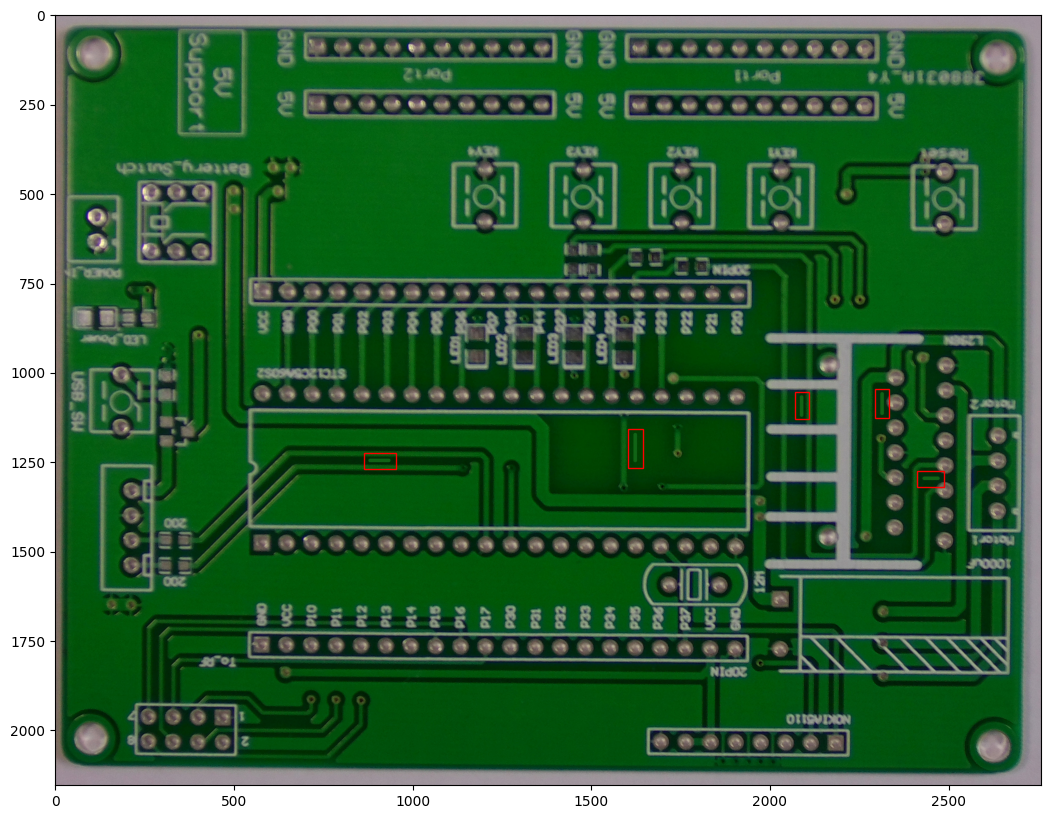

In [ ]:
name = data.file[482]
plot_image(name)

# IV. Creating Custom database

In [ ]:
class fcbData(object):
    def __init__(self, df, IMG_DIR, transforms):
        self.df = df
        self.img_dir = IMG_DIR
        self.image_ids = self.df['file'].unique().tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        a = ''
        if "missing" in image_id.split('_'):
            a = 'Missing_hole/'
        elif "mouse" in image_id.split('_'):
            a = 'Mouse_bite/'
        elif "open" in image_id.split('_'):
            a = 'Open_circuit/'
        elif "short" in image_id.split('_'):
            a = 'Short/'
        elif "spur" in image_id.split('_'):
            a = 'Spur/'
        elif "spurious" in image_id.split('_'):
            a = 'Spurious_copper/'
        image_values = self.df[self.df['file'] == image_id]
        image = cv2.imread(self.img_dir+a+image_id+".jpg",cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = image_values[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        labels = image_values["class"].values
        labels = torch.tensor(labels)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.as_tensor(area, dtype=torch.float32)
        target['iscrowd'] = torch.zeros(len(classes_la), dtype=torch.int64)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }

            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, image_id

Define the image transformations. We'll use albumentations package: https://albumentations.ai/


In [ ]:
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
path ="/content/drive/MyDrive/PCB_Dataset/images/"
fcb_dataset   = fcbData(df, path, get_train_transform())

In [ ]:
len(fcb_dataset)

693

In [ ]:
first_data=fcb_dataset[0]
type(first_data), len(first_data), type(first_data[0]), type(first_data[1]), type(first_data[2])

(tuple, 3, torch.Tensor, dict, str)

In [ ]:
print(first_data[0], first_data[1], first_data[2])

tensor([[[0.5765, 0.5686, 0.5569,  ..., 0.6157, 0.6000, 0.6118],
         [0.5765, 0.5765, 0.5608,  ..., 0.6078, 0.5961, 0.6078],
         [0.5804, 0.5922, 0.5922,  ..., 0.6039, 0.5961, 0.6039],
         ...,
         [0.5490, 0.5725, 0.5608,  ..., 0.5922, 0.5922, 0.6039],
         [0.5647, 0.5490, 0.5647,  ..., 0.5922, 0.5804, 0.5922],
         [0.5686, 0.5529, 0.5608,  ..., 0.5882, 0.6000, 0.6118]],

        [[0.5412, 0.5333, 0.5216,  ..., 0.5922, 0.5765, 0.5882],
         [0.5373, 0.5373, 0.5255,  ..., 0.5843, 0.5725, 0.5843],
         [0.5412, 0.5529, 0.5529,  ..., 0.5804, 0.5725, 0.5804],
         ...,
         [0.5255, 0.5490, 0.5373,  ..., 0.5725, 0.5725, 0.5843],
         [0.5451, 0.5216, 0.5373,  ..., 0.5843, 0.5725, 0.5843],
         [0.5490, 0.5255, 0.5333,  ..., 0.5804, 0.5922, 0.6039]],

        [[0.5451, 0.5373, 0.5255,  ..., 0.6078, 0.5922, 0.6039],
         [0.5412, 0.5412, 0.5294,  ..., 0.6000, 0.5882, 0.6000],
         [0.5451, 0.5569, 0.5569,  ..., 0.5961, 0.5882, 0.

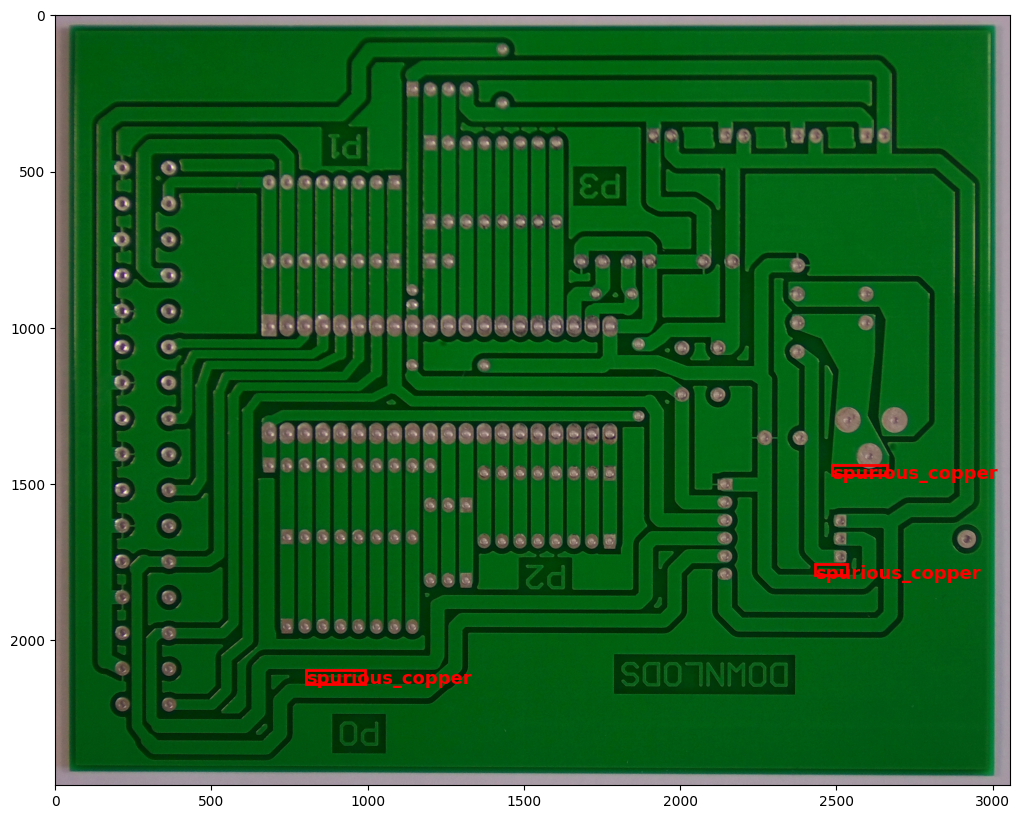

In [ ]:
img, tar, _ = fcb_dataset[random.randint(0,50)]
bbox = tar['boxes']
fig,ax = plt.subplots(figsize=(18,10))
ax.imshow(img.permute(1,2,0).cpu().numpy())
for j in tar["labels"].tolist():
    classes_la = {1:"missing_hole", 2: "mouse_bite", 3:"open_circuit",4: "short", 5:'spur',6:'spurious_copper'}
    l = classes_la[j]
    for i in range(len(bbox)):
        box = bbox[i]
        x,y,w,h = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = matplotlib.patches.Rectangle((x,y),w,h,linewidth=2,edgecolor='r',facecolor='none',)
        ax.text(*box[:2], l, verticalalignment='top', color='red', fontsize=13, weight='bold')
        ax.add_patch(rect)
    plt.show()

In [ ]:
image_ids=df['file'].unique()
print(len(image_ids))

693


Split data into training and test

In [ ]:
valid_df = train.sample(frac=0.1, random_state=42)
indices_to_remove = valid_df.index
train_df = train.drop(indices_to_remove)
test_df = test
train_df.shape,valid_df.shape

((2126, 8), (236, 8))

# V. Dataloader

In [ ]:
path

'/content/drive/MyDrive/PCB_Dataset/images/'

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dataset = fcbData(train_df, path, get_train_transform())
valid_dataset = fcbData(valid_df, path, get_valid_transform())
test_dataset  = fcbData(test_df , path, get_test_transform() )

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=6,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=6,
    collate_fn=collate_fn
)

In [ ]:
print(len(train_data_loader),len(valid_data_loader),len(test_data_loader))

688 206 405


Most pretrained models are trained with a background class, we'll include it in our model, so in that case our number of classes will be 6

In [ ]:
def load_model():
    ## num_classes = 6 # + background
    num_classes = 6+1

    # load a model; pre-trained on COCO
    # .. fpn = 'feature pyramid network'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device ",device)

Using device  cuda


In [ ]:
model=load_model()
for name, params in model.named_parameters():
    if params.requires_grad and name.__contains__("predict"):
        print(name)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 141MB/s]


roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [ ]:
def load_params():
    model=load_model().to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    return model,params,optimizer,lr_scheduler

# VI. Training and evaluation

In [ ]:
train_data_loader

In [ ]:
def orthogonal_loss(lembda):
    extra_norm=0.
    for m in model.modules():
        if isinstance(m,torch.nn.Linear) or isinstance(m,torch.nn.Conv2d):
            tmp=m.weight.view(m.weight.data.size(0), -1)
            s1,s2=tmp.shape # For unequal matrices semi orthogonal condition is imposed
            if s1<s2:
                extra_norm+=torch.norm(torch.mm(tmp,tmp.t())-torch.eye(s1).to(device),p='fro')
            else:
                extra_norm+=torch.norm(torch.mm(tmp.t(),tmp)-torch.eye(s2).to(device),p='fro')
    return lembda*extra_norm

In [ ]:
lembdas = [0.0001,0.01]
loss_curves = []
IOU_curves = []
models  = []

for lembda in lembdas:

    min_loss = sys.maxsize
    num_epochs = 25

    model=load_model().to(device)
    models.append(model)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005,)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    loss_curve=[]
    IOU_curve=[]

    for epoch in range(num_epochs):
        tk = tqdm(train_data_loader)
        model.train()
        running_loss = 0.
        for images, targets, image_ids in tk:
            # Shifting everything to CUDA (NO CHANGE IN DATA)
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses + orthogonal_loss(lembda)
            running_loss+=loss_value.item()

            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            loss_curve.append(loss_value.item())
            tk.set_postfix(train_loss=loss_value.item())
        tk.close()
        running_loss/=len(train_data_loader)
        loss_curve.append(running_loss)

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_value.item()}")

        #validation
        model.eval();
        with torch.no_grad():
            tk = tqdm(valid_data_loader)
            running_IOU=0.
            for images, targets, image_ids in tk:
                # Shifting everthing to CUDA (NO CHANGE IN DATA)
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                val_output = model(images)
                val_output = [{k: v.to(device) for k, v in t.items()} for t in val_output]
                IOU = []
                for j in range(len(val_output)):
                    a,b = val_output[j]['boxes'].cpu().detach(), targets[j]['boxes'].cpu().detach()
                    chk = torchvision.ops.box_iou(a,b)
                    res = np.nanmean(chk.sum(axis=1)/(chk>0).sum(axis=1))
                    if np.isnan(res):
                        res = 0.0
                    IOU.append(res)
                running_IOU += np.nanmean(IOU)
                tk.set_postfix(IoU=np.nanmean(IOU))
            running_IOU/=len(valid_data_loader)
            IOU_curve.append(running_IOU)
            tk.close()
        print("IOU Average Measure ",IOU_curve[-1])
    IOU_curves.append(IOU_curve)
    loss_curves.append(loss_curve)
    models.append(model)

  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #0 loss: 0.4445248246192932


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.47073618517917337


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #1 loss: 0.5819534659385681


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.5551441296645738


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #2 loss: 0.2669943869113922


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6094045210810541


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #3 loss: 0.2268194854259491


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.66248145055713


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #4 loss: 0.3289892077445984


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6839368048223476


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #5 loss: 0.39727115631103516


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6919843953790017


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #6 loss: 0.25661590695381165


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6960267980121871


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #7 loss: 0.25452086329460144


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6933108845960747


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #8 loss: 0.3727317154407501


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6936063633020063


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #9 loss: 0.2706837058067322


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6957200180051974


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #10 loss: 0.23215943574905396


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6978537205932209


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #11 loss: 0.18781018257141113


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6964522174478156


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #12 loss: 0.20713773369789124


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6979627317378243


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #13 loss: 0.37530428171157837


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6977869563021706


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #14 loss: 0.21057914197444916


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6981896194584162


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #15 loss: 0.36147060990333557


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6980077602258585


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #16 loss: 0.22387774288654327


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6980276630413764


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #17 loss: 0.30654376745224


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6981659641905317


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #18 loss: 0.19689872860908508


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6978344144390046


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #19 loss: 0.2839769721031189


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6980501721495563


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #20 loss: 0.25856971740722656


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6980217693427813


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #21 loss: 0.19716519117355347


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6981719458855472


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #22 loss: 0.3687375783920288


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6978406872853492


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #23 loss: 0.32945191860198975


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6981682911225893


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #24 loss: 0.36904752254486084


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.698168229203201


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #0 loss: 7.547088623046875


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.5314495741452986


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #1 loss: 6.099040985107422


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.5154650535217478


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #2 loss: 4.968277931213379


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.5741075661431239


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #3 loss: 4.837602138519287


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6540417650949608


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #4 loss: 4.672501087188721


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6817488981392777


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #5 loss: 4.727567672729492


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6786633565009219


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #6 loss: 4.667143821716309


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6866138953245381


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #7 loss: 4.7504096031188965


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6890434551694729


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #8 loss: 4.653561592102051


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6887640647807167


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #9 loss: 4.647031307220459


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6897088386190747


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #10 loss: 4.579792499542236


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6909045487352945


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #11 loss: 4.6349639892578125


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6910013815442335


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #12 loss: 4.705157279968262


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6909990958797122


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #13 loss: 4.666068077087402


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6913265516457049


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #14 loss: 4.623227119445801


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914387516026358


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #15 loss: 4.721745014190674


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914398945072322


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #16 loss: 4.724899768829346


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914415910695363


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #17 loss: 4.71296501159668


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914865017226599


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #18 loss: 4.5772929191589355


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914406073035546


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #19 loss: 4.536805629730225


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914425153755447


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #20 loss: 4.585639953613281


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914423932728259


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #21 loss: 4.6331281661987305


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914437977434362


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #22 loss: 4.532320976257324


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914420919221582


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #23 loss: 4.677248477935791


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914878713274465


  0%|          | 0/688 [00:00<?, ?it/s]

Epoch #24 loss: 4.61702299118042


  0%|          | 0/206 [00:00<?, ?it/s]

IOU Average Measure  0.6914879043125411


In [ ]:
!pip install seaborn
import seaborn as sns

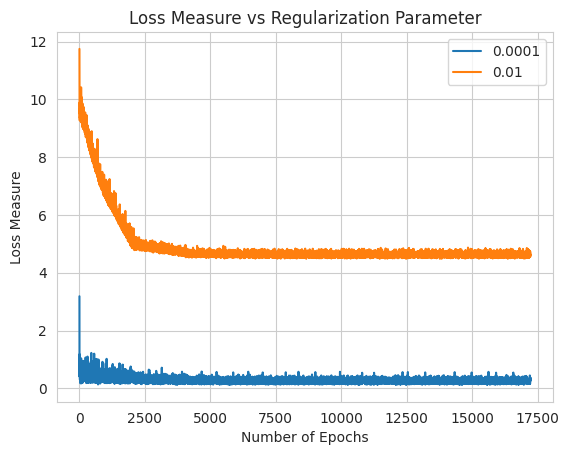

In [ ]:
sns.set_style('whitegrid')
for lc,l in zip(loss_curves,lembdas):
    plt.plot(lc,label=l)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss Measure")
plt.title("Loss Measure vs Regularization Parameter")
plt.savefig('loss_curves.png')
plt.show()

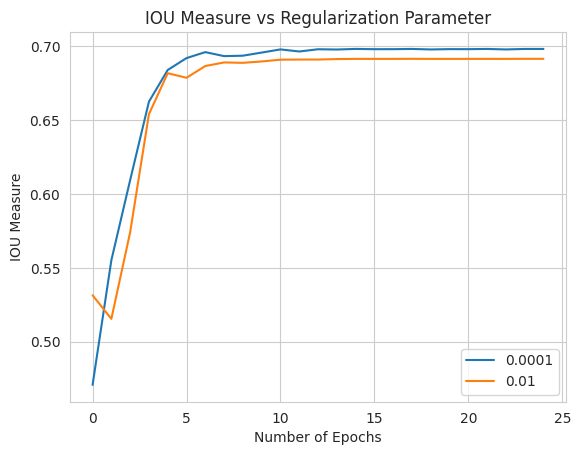

In [ ]:
for ic,l in zip(IOU_curves,lembdas):
    plt.plot(ic,label=l)
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("IOU Measure")
plt.title("IOU Measure vs Regularization Parameter")
plt.savefig('iou_curves.png')
plt.show()

##### Sample evaluation on validation dataset image

In [ ]:
img,target,_ = valid_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['boxes']))
print('real #boxes: ', len(target['boxes']))

predicted #boxes:  3
real #boxes:  1


In [ ]:
for model,lembda in zip(models,lembdas):
    model_path = 'model_{}.pth'.format(lembda)
    torch.save(model.state_dict(),model_path)

# VII. Evaluation

In [ ]:
# y_true =[]
# y_pred = []
# for data in valid_dataset:
#     img,target,_ = data
#     model.eval()
#     with torch.no_grad():
#         y_true.append(target['labels'][0])
#         prediction = model([img.to(device)])[0]
#         if len(prediction['labels'])==0:
#             y_pred.append(torch.tensor(0).to(device))
#         else:
#             y_pred.append(prediction['labels'][0])

In [ ]:
# yy_pred = []
# for v in y_pred:
#     yy_pred.append(v.cpu())

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_true, yy_pred)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(y_true, yy_pred))

In [ ]:
# # Define the device for inference (CPU or GPU)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# defect_names = {
#     1: "Missing Hole",
#     2: "Open Circuit",
#     3: "Short Circuit",
#     4: "Mouse Bite",
#     5: "Spur",
#     6: "Copper Trace Cut"
# }
# # Load the model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=7)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)
# model.load_state_dict(torch.load('/kaggle/working/pcbdetection.pt'))
# model.eval()
# model.to(device)

# # Load the image
# image_path = '/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite/01_mouse_bite_06.jpg'
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image / 255.0

# # Define the transformation to apply to the image
# transform = T.Compose([T.ToTensor()])

# # Apply the transformation to the image
# image = transform(image).to(device)

# # Predict the bounding boxes and labels for the image
# image = image.float()
# outputs = model([image])
# boxes = outputs[0]['boxes'].detach().cpu().numpy()
# labels = outputs[0]['labels'].detach().cpu().numpy()

# # Visualize the image and the predicted bounding boxes
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.imshow(image.permute(1, 2, 0).cpu().numpy())
# for box, label in zip(boxes, labels):
#     x1, y1, x2, y2 = box
#     w, h = x2 - x1, y2 - y1
#     rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     ax.text(x1-20, y2 + 150, defect_names[label], fontsize=12, color='g', backgroundcolor='w')
# plt.show()

# VIII. Testing Results

In [ ]:
# load_path = '../input/models-and-results-with-10-eopchs/'
# os.listdir(load_path)

In [ ]:
# lembdas=[0.0,0.0001,0.001,0.01]
# models= []
# for lembda in lembdas:
#     model_path = 'model_{}.pth'.format(lembda)
#     model_path=load_path+model_path
#     print(model_path)
#     model=load_model()
#     checkpoint=torch.load(model_path)
#     models.append(model)

In [ ]:
# Define the device for inference (CPU or GPU)
def check(model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    defect_names = {
        1: "Missing Hole",
        2: "Open Circuit",
        3: "Short Circuit",
        4: "Mouse Bite",
        5: "Spur",
        6: "Copper Trace Cut"
    }

    model.eval()
    model.to(device)

    # Load the image
    image_path = '/content/drive/MyDrive/PCB_Dataset/custom_images/pcb_4.jpg'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0

    # Define the transformation to apply to the image
    transform = T.Compose([T.ToTensor()])

    # Apply the transformation to the image
    image = transform(image).to(device)

    # Predict the bounding boxes and labels for the image
    image = image.float()
    with torch.no_grad():
        outputs = model([image])
    print(outputs[0])
    boxes = outputs[0]['boxes'].detach().cpu().numpy()
    labels = outputs[0]['labels'].detach().cpu().numpy()
    scores = outputs[0]['scores'].detach().cpu().numpy()

    # Visualize the image and the predicted bounding boxes
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = matplotlib.patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, f"{defect_names[label]}: {score:.2f}", fontsize=12, color='white', backgroundcolor='red')
    plt.show()
    plt.clf()
    plt.close('all')

{'boxes': tensor([[1164.8893, 1205.8759, 1224.8557, 1265.3472],
        [2134.0933,  856.3612, 2200.8352,  910.8449],
        [ 909.1732, 1107.7917,  979.0490, 1168.8230],
        [ 900.4415, 1109.7666,  979.6737, 1172.4064],
        [ 885.3217, 1121.5004,  955.6545, 1177.9890]], device='cuda:0'), 'labels': tensor([3, 3, 3, 2, 5], device='cuda:0'), 'scores': tensor([0.9736, 0.9583, 0.9355, 0.1693, 0.0912], device='cuda:0')}


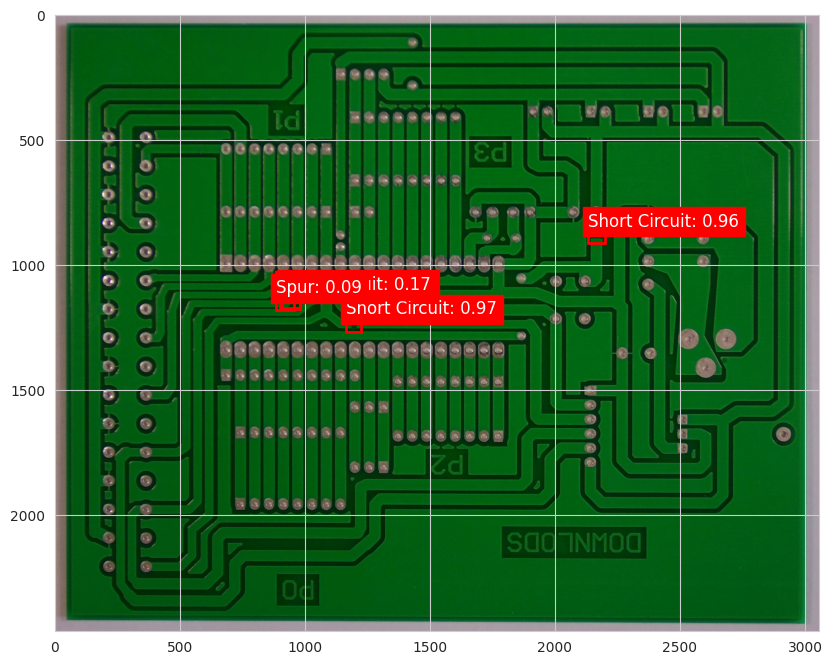

{'boxes': tensor([[1164.8893, 1205.8759, 1224.8557, 1265.3472],
        [2134.0933,  856.3612, 2200.8352,  910.8449],
        [ 909.1732, 1107.7917,  979.0490, 1168.8230],
        [ 900.4415, 1109.7666,  979.6737, 1172.4064],
        [ 885.3217, 1121.5004,  955.6545, 1177.9890]], device='cuda:0'), 'labels': tensor([3, 3, 3, 2, 5], device='cuda:0'), 'scores': tensor([0.9736, 0.9583, 0.9355, 0.1693, 0.0912], device='cuda:0')}


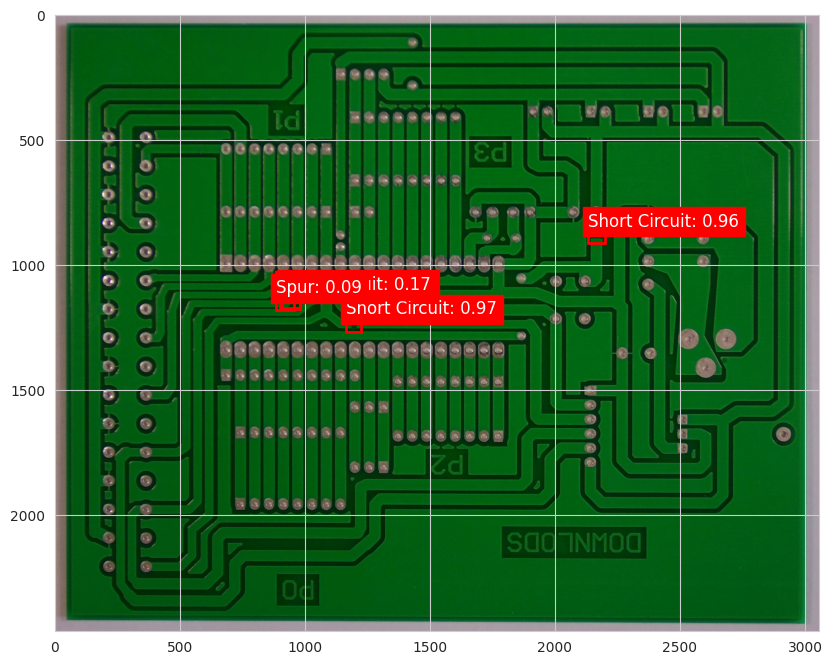

{'boxes': tensor([[1165.2806, 1206.1901, 1227.0050, 1264.3972],
        [2136.1064,  858.1171, 2199.7537,  908.8839],
        [ 912.0408, 1111.8625,  975.2881, 1163.0104],
        [ 905.4690, 1113.1932,  973.6933, 1169.4817],
        [ 887.5421, 1114.2383,  961.8638, 1174.6180]], device='cuda:0'), 'labels': tensor([3, 3, 3, 2, 5], device='cuda:0'), 'scores': tensor([0.9731, 0.9519, 0.9352, 0.1259, 0.0755], device='cuda:0')}


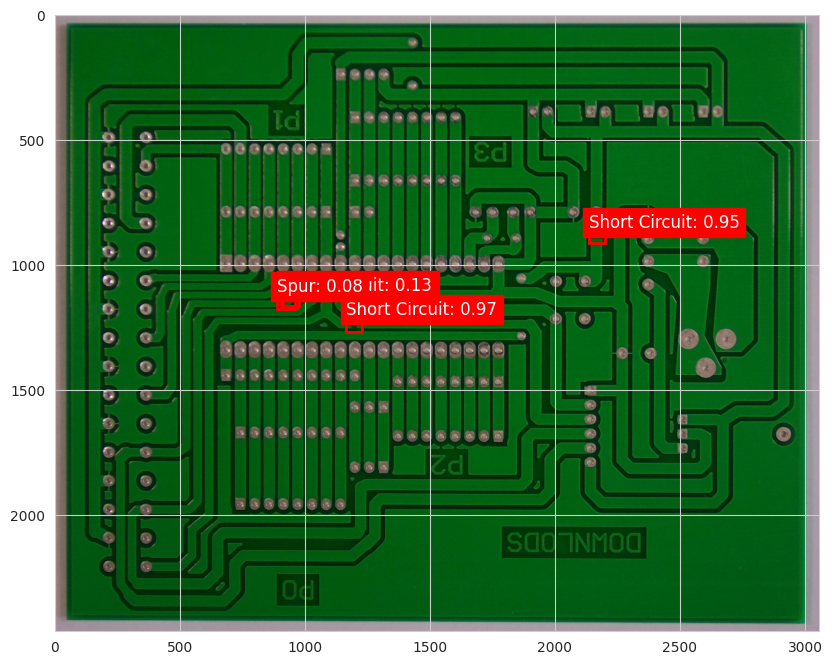

{'boxes': tensor([[1165.2806, 1206.1901, 1227.0050, 1264.3972],
        [2136.1064,  858.1171, 2199.7537,  908.8839],
        [ 912.0408, 1111.8625,  975.2881, 1163.0104],
        [ 905.4690, 1113.1932,  973.6933, 1169.4817],
        [ 887.5421, 1114.2383,  961.8638, 1174.6180]], device='cuda:0'), 'labels': tensor([3, 3, 3, 2, 5], device='cuda:0'), 'scores': tensor([0.9731, 0.9519, 0.9352, 0.1259, 0.0755], device='cuda:0')}


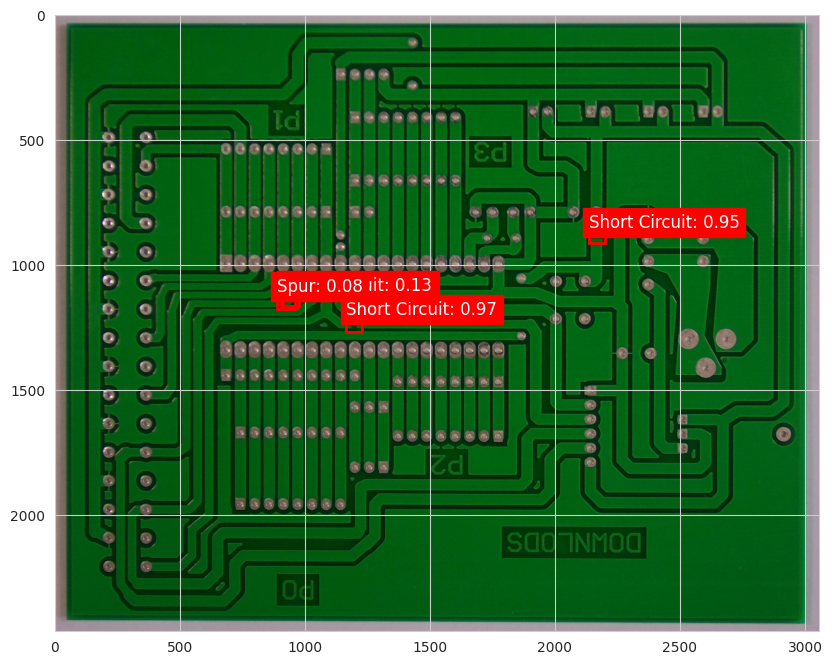

In [ ]:
for model in models:
    check(model)